# Bridge Condition Analysis and Prediction: A Statistical Approach for the Texas Department of Transportation

## Executive Summary and Outline

This report presents a comprehensive analysis of Texas bridge infrastructure data for the Texas Department of Transportation. Our primary objectives are to evaluate the effectiveness of proposed variables in predicting bridge conditions and to determine which factors have the most significant influence on current bridge conditions.

The analysis examines several critical aspects of bridge infrastructure, focusing on the age of the bridge, average daily use, percentage of truck traffic, construction material, and design specifications. Additionally, we incorporate component ratings, including deck, superstructure, and substructure ratings, to develop a comprehensive understanding of bridge conditions.

Our methodological approach combines quantitative and qualitative analysis through three main phases. We begin with thorough data preprocessing to ensure data quality and reliability. This is followed by exploratory data visualization to identify patterns and relationships within the data. Finally, we employ linear regression modeling to assess the impact of predictor variables on bridge conditions.

Throughout this report, we not only present what the data reveals but also provide detailed explanations of our data processing methods and analytical assumptions. This transparency in our approach ensures the validity of our conclusions and supports informed decision-making for bridge infrastructure management.


 1. Section 1: Data Preparation
     1. Age Variable Derivation
     1. Historic Bridge Filtering
     1. Simplification of Categorical Variables
     1. Condition Score Derivation
     1. Distributions ofVariables and Review of Outliers

 1. Section 2: Initial Data Investigation and Pattern Recognition
     1. Correlation of Continuous Variables
        1. The Correlation Matrix
        1. The Scatter Matrix
     1. Analysis of Category Interactions
        1. Distribution Analysis Visualization
        2. Conditional Probability Visualization
     1. Numerical Variable Patterns Across Categories
     1. Findings of Exploratory Analysis

 1. Section 3: Statistical Modeling and Results Interpretation
     1. Model Development
     1. Model Performance Metrics
     1. Distribution of Residuals
     1. Comparing the Effects of Predictor Variables
     1. Conclusion and Prediction

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns

%matplotlib inline

In [7]:
# Read the CSV file
df = pd.read_csv('tx19_bridges_sample.csv')

## Section 1:Data Preparation

This section prepares the Texas bridge dataset for condition analysis, focusing on variable derivation and data refinement to ensure the accuracy and reliability of subsequent analytical models.

### Section 1.1 Age Variable Derivation

Age serves as a fundamental factor in bridge deterioration analysis. The standardized age tracking enables monitoring of condition changes and maintenance patterns, supporting lifecycle assessment and maintenance planning across bridge types.



In [9]:
# Calculate bridge age
current_year = 2024
df_copy = df.copy()
df_copy['Age'] = current_year - df_copy['Year']

Implementation notes:
* Age calculation: 2024 - Construction year for all structures

### Section 1.2 Historic Bridge Filtering

Historic bridges often employ outdated construction techniques and materials, and typically follow specialized maintenance protocols that differ from modern structures. Including these bridges in our analysis could skew our understanding of how contemporary bridges deteriorate, potentially leading to incorrect conclusions about maintenance needs for the broader bridge population.

In [11]:
# Exclude very old bridges
# Calculate the median age of bridges in the 'Register' type
register_median_age = df_copy[df_copy['Historic'] == 'Register']['Age'].median()

# Create a boolean mask to identify bridges to keep
keep_mask = (
    (df_copy['Historic'] == 'Not historic') |
    ((df_copy['Historic'] == 'Possible') & (df_copy['Age'] <= register_median_age)) |
    (df_copy['Historic'] == 'Unknown')
)

# Apply the mask to filter the data and reset the index
df_filtered = df_copy[keep_mask].reset_index(drop=True)

Implementation notes:

* Excluded bridges: Confirmed historic status or age above historical median
* Retained bridges: Non-historic, ppossible historic below threshold, or unknown status
* Rationale: Ensure analysis reflects contemporary bridge conditions and practice

### Section 1.3 Simplification of Categorical Variables

Material and design categories were consolidated to ensure statistical reliability. The original dataset contained multiple categories with insufficient samples, which could lead to unstable analysis. Grouping was performed to maintain key structural distinctions while achieving adequate sample sizes.

In [13]:
# Merge small categories of materials and design
material_counts = df_filtered['Material'].value_counts()
design_counts = df_filtered['Design'].value_counts()

# print("Each type and corresponding counts in the 'Material' column:")
# print(material_counts)
# print("\nEach type and corresponding counts in the 'Design' column:")
# print(design_counts)

# Merge small categories in the 'Material' column
def merge_material_categories(material):
   if material in ['Concrete', 'Steel']:
       return material
   else:
       return 'Timber/Other'

df_filtered['Material_Merged'] = df_filtered['Material'].apply(merge_material_categories)

# Merge small categories in the 'Design' column
def merge_design_categories(design):
   if design in ['Beam', 'Slab']:
       return design
   else:
       return 'Arch/Other'

df_filtered['Design_Merged'] = df_filtered['Design'].apply(merge_design_categories)

Implementation notes:

* Materials: Concrete, Steel, Timber/Other
* Designs: Beam, Slab, Arch/Other

### Section 1.4 Condition Score Derivation

Bridge condition ratings were converted from qualitative to numerical scores to enable quantitative analysis. The composite score combines deck, superstructure, and substructure ratings into a single metric, reflecting overall bridge condition while preserving component-level assessments.

In [16]:
# Calculate the overall condition score
# Transfer three current condition variables to continuous variable

# print(df_filtered['Deck_rating'].unique())
# print(df_filtered['Superstr_rating'].unique())
# print(df_filtered['Substr_rating'].unique())

# Define the mapping from rating to score
rating_to_score = {
    'Excellent': 9,
    'Very Good': 8,
    'Good': 7,
    'Satisfactory': 6,
    'Fair': 5,
    'Poor': 4,
    'Serious': 3,
    'Critical': 2,
    'Failing': 1,
    'Failed': 0
}

rating_columns = ['Deck_rating', 'Superstr_rating', 'Substr_rating']
df_clean = df_filtered.dropna(subset=rating_columns).copy()

# Function to convert ratings to scores
def convert_rating_to_score(rating):
    return rating_to_score.get(rating)

# Apply the conversion to rating columns
for col in rating_columns:
    df_clean[col] = df_clean[col].apply(convert_rating_to_score)

# Calculate the total current condition score
df_clean['Current_condition_score'] = df_clean[rating_columns].sum(axis=1)

Implementation notes:

* Numerical conversion: 0 (Failed) to 9 (Excellent) for each rating
* Components assessed: Deck, superstructure, substructure ratings
* Composite score: Sum of three component scores (range 0-27)
* Score interpretation: Higher values indicate better bridge condition

### Section 1.5 Distributions of Variables and Review of Outliers

In [18]:
df_clean.describe().round(2)

,Detour_Km,Year,Lanes_on,Lanes_under,AverageDaily,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Future_traffic,Age,Current_condition_score
count,32245.00,32245.00,32245.00,32245.00,32245.00,32245.00,32245.00,32245.00,32245.00,32245.00,32245.00,32245.00,32245.00,32245.00,32245.00,32245.00
mean,10.68,1984.67,2.40,1.79,12064.27,3.74,94.73,11.87,6.86,6.93,6.63,30.02,8.45,17432.80,39.33,20.42
std,26.84,20.73,1.24,3.81,24857.31,5.00,189.21,6.57,0.71,0.85,0.81,5.11,10.32,36855.39,20.73,1.94
min,0.00,1930.00,1.00,0.00,0.00,0.00,6.10,2.50,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00
25%,2.00,1967.00,2.00,0.00,340.00,1.00,24.40,7.30,7.00,6.00,6.00,26.30,0.00,450.00,21.00,19.00
50%,3.00,1987.00,2.00,0.00,3400.00,3.00,48.80,10.90,7.00,7.00,7.00,32.70,5.00,4800.00,37.00,21.00
75%,8.00,2003.00,2.00,2.00,12330.00,4.00,89.90,13.40,7.00,8.00,7.00,32.70,13.00,17610.00,57.00,22.00
max,999.00,2019.00,15.00,99.00,543000.00,194.00,6270.30,228.00,9.00,9.00,9.00,99.90,99.00,999999.00,94.00,27.00


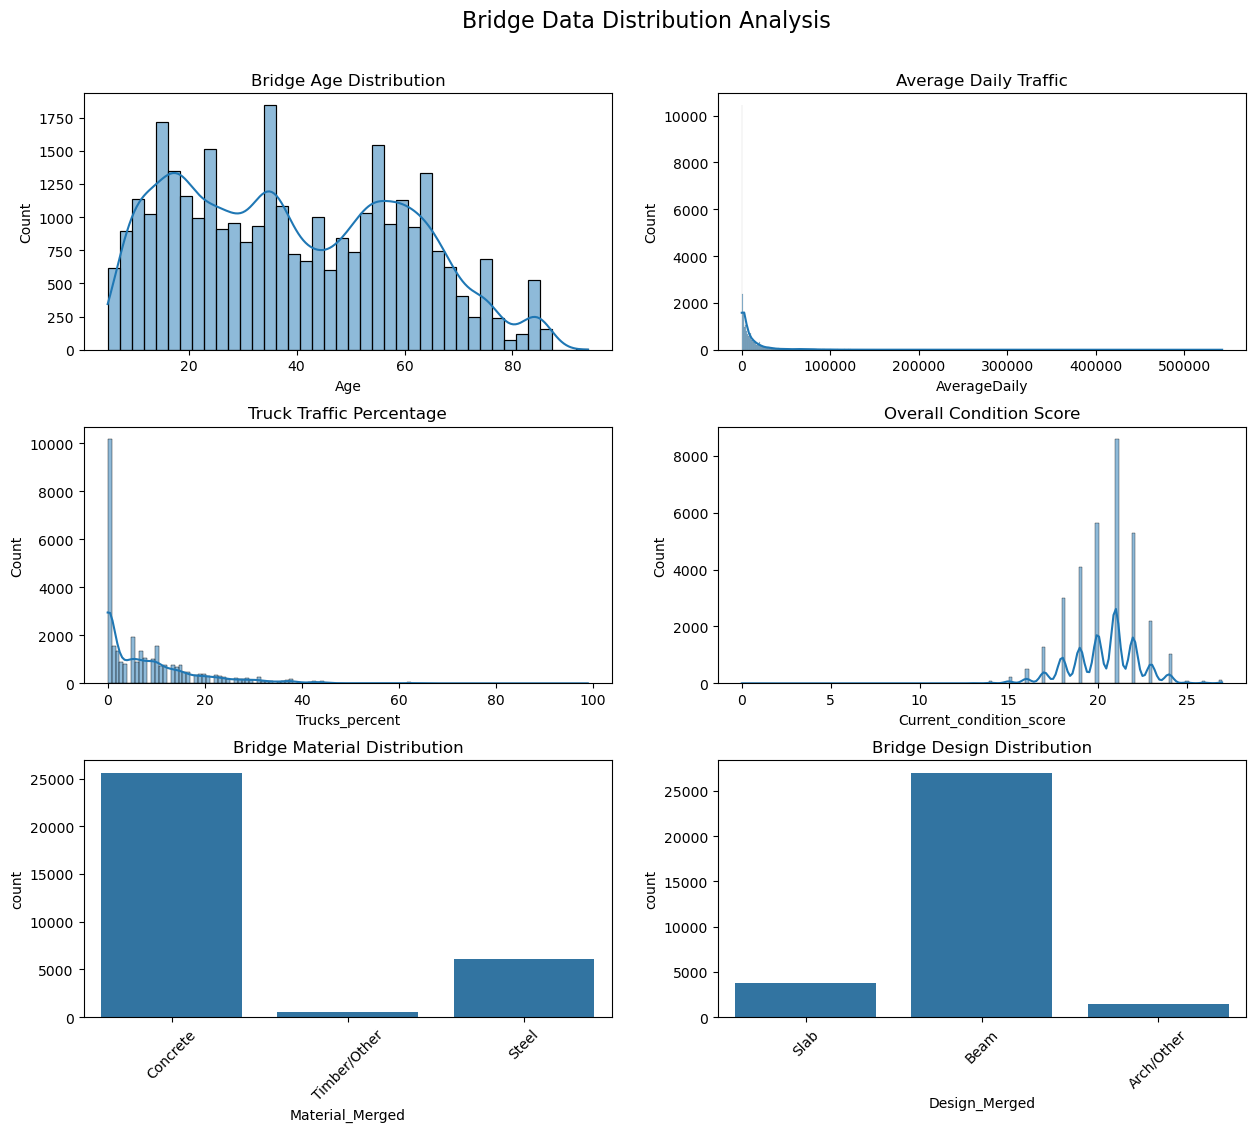

In [19]:
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(3, 2)
gs.update(hspace=0.3, wspace=0.2)

# Age distribution
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(data=df_clean, x='Age', kde=True, ax=ax1)
ax1.set_title('Bridge Age Distribution')

# Daily traffic distribution
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data=df_clean, x='AverageDaily', kde=True, ax=ax2)
ax2.set_title('Average Daily Traffic')

# Truck percentage
ax3 = fig.add_subplot(gs[1, 0])
sns.histplot(data=df_clean, x='Trucks_percent', kde=True, ax=ax3)
ax3.set_title('Truck Traffic Percentage')

# Condition score
ax4 = fig.add_subplot(gs[1, 1])
sns.histplot(data=df_clean, x='Current_condition_score', kde=True, ax=ax4)
ax4.set_title('Overall Condition Score')

# Material distribution
ax5 = fig.add_subplot(gs[2, 0])
sns.countplot(data=df_clean, x='Material_Merged', ax=ax5)
ax5.set_title('Bridge Material Distribution')
ax5.tick_params(axis='x', rotation=45)

# Design distribution
ax6 = fig.add_subplot(gs[2, 1])
sns.countplot(data=df_clean, x='Design_Merged', ax=ax6)
ax6.set_title('Bridge Design Distribution')
ax6.tick_params(axis='x', rotation=45)

plt.suptitle('Bridge Data Distribution Analysis', fontsize=16, y=0.95)
plt.show()

The bridge infrastructure data reveals interesting patterns across four key dimensions：

1. **Age Distribution**: Peaks around 20, 40, and 60 years reflect distinct waves of development, corresponding to historical infrastructure initiatives and economic growth. The highest concentration of bridges is 20-25 years old, indicating a significant construction boom in the late 1990s to early 2000s.

2. **Traffic Patterns**: Most bridges serve local communities with moderate volumes, while a few major arterial bridges handle extremely high daily traffic, up to 500,000 vehicles. This contrast underscores the hierarchical nature of the transportation network, where a few key urban bridges manage major flows, while most rural and suburban bridges support smaller communities.

3. **Truck Traffic Percentage**: Predominantly low truck percentages (below 20%) indicate most bridges mainly serve passenger vehicles. This aligns with the tendency for commercial traffic to concentrate on specific freight corridors rather than being evenly distributed.

4. **Condition Scores**: Clustered scores between 15-25. Most bridges are maintained at acceptable levels, though lower scores point to specific infrastructure needing attention, which appears relatively uncommon.

5. **Material Distribution**: The bridge material data shows that concrete is by far the most common choice, making up about 75% (25,000) of all bridges. Steel bridges come in second at 20% (6,000), while other materials (including timber) account for only 5% of all bridges. This shows that engineers strongly prefer concrete and steel for their reliability and durability.

6. **Design Distribution**: Looking at bridge designs, beam-style bridges strongly dominate, accounting for 80% (27,000) of all structures. Slab bridges make up about 12% (4,000) of the total, while other designs (including arch and truss bridges) represent only 8% (2,000) of all bridges. This simplified pattern shows that engineers prefer straightforward beam and slab designs for most situations.

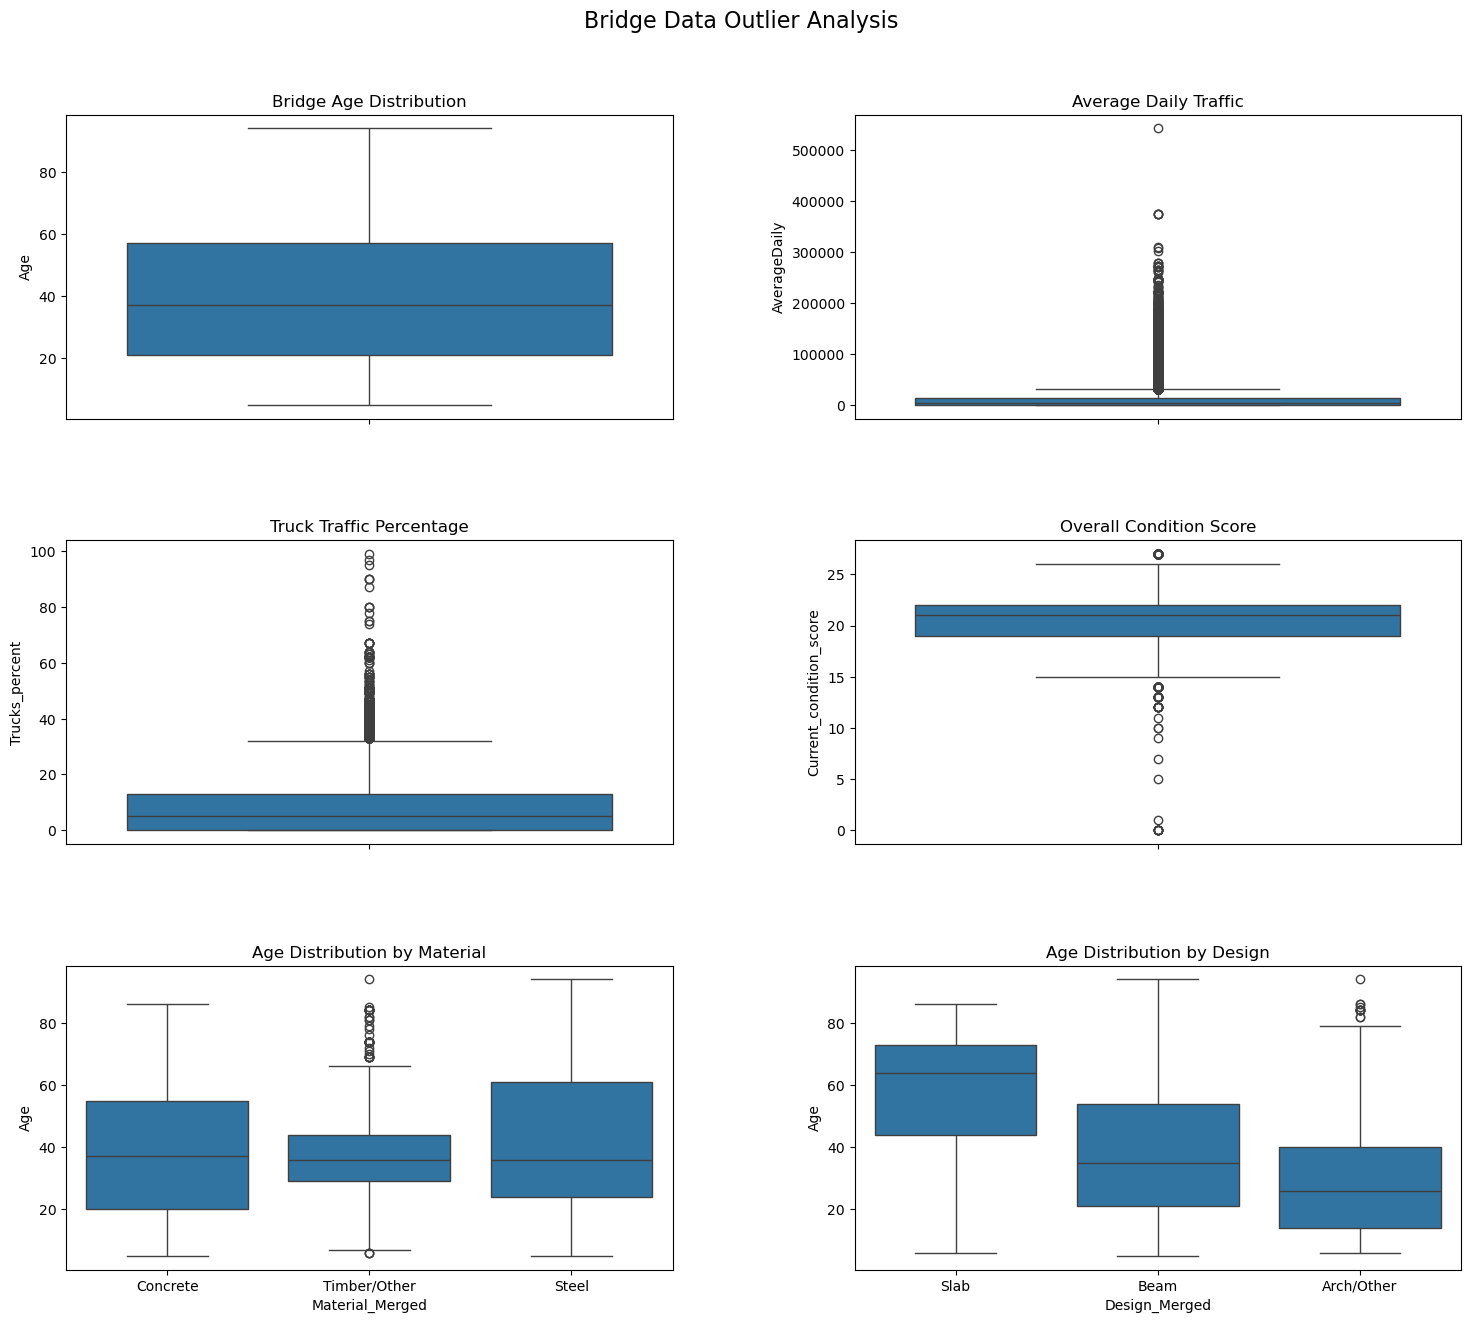

In [21]:
fig = plt.figure(figsize=(18, 15))
gs = fig.add_gridspec(3, 2)
gs.update(hspace=0.4, wspace=0.3)

# Age Distribution
ax1 = fig.add_subplot(gs[0, 0])
sns.boxplot(data=df_clean, y='Age', ax=ax1)
ax1.set_title('Bridge Age Distribution')

# Daily Traffic
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(data=df_clean, y='AverageDaily', ax=ax2)
ax2.set_title('Average Daily Traffic')

# Truck Percentage
ax3 = fig.add_subplot(gs[1, 0])
sns.boxplot(data=df_clean, y='Trucks_percent', ax=ax3)
ax3.set_title('Truck Traffic Percentage')

# Condition Score
ax4 = fig.add_subplot(gs[1, 1])
sns.boxplot(data=df_clean, y='Current_condition_score', ax=ax4)
ax4.set_title('Overall Condition Score')

# Material by Age
ax5 = fig.add_subplot(gs[2, 0])
sns.boxplot(data=df_clean, x='Material_Merged', y='Age', ax=ax5)
ax5.set_title('Age Distribution by Material')

# Design by Age
ax6 = fig.add_subplot(gs[2, 1])
sns.boxplot(data=df_clean, x='Design_Merged', y='Age', ax=ax6)
ax6.set_title('Age Distribution by Design')

plt.suptitle('Bridge Data Outlier Analysis', fontsize=16, y=0.95)
plt.show()

Outlier Analysis Summary:

1. **Average Daily Traffic**: Shows clear outliers up to 500,000 vehicles per day. These extreme values likely represent critical bridges in major urban areas or highways rather than data errors.

2. **Truck Traffic Percentage**: Contains a few extreme values reaching 80-100%. Rather than errors, these outliers might indicate specialized industrial corridors or dedicated freight routes.

3. **Overall Condition Score**: Has outliers at both ends (0-5 and around 25). Since this is a rating system, extremely low scores might genuinely reflect bridges requiring maintenance rather than scoring errors.

4. **Age by Material/Design**: All categories show extreme ages over 80 years, particularly in Steel material and Slab design. These likely represent historical structures requiring special attention rather than data anomalies.

At this stage, we should retain these extreme values for further analysis as they may indicate important infrastructure characteristics or areas needing special attention.

In [23]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32245 entries, 0 to 32251
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Structure_id             32245 non-null  object 
 1   District                 32245 non-null  object 
 2   Detour_Km                32245 non-null  int64  
 3   Toll                     32245 non-null  object 
 4   Maintainer               32245 non-null  object 
 5   Urban                    32245 non-null  object 
 6   Status                   32245 non-null  object 
 7   Year                     32245 non-null  int64  
 8   Lanes_on                 32245 non-null  int64  
 9   Lanes_under              32245 non-null  int64  
 10  AverageDaily             32245 non-null  int64  
 11  Historic                 32245 non-null  object 
 12  Service_under            32245 non-null  object 
 13  Material                 32245 non-null  object 
 14  Design                   32

In [24]:
df_clean[['Structure_id', 'Age', 'AverageDaily', 'Historic',
          'Material_Merged', 'Design_Merged', 'Trucks_percent',
          'Deck_rating', 'Superstr_rating', 'Substr_rating', 'Current_condition_score']]

,Structure_id,Age,AverageDaily,Historic,Material_Merged,Design_Merged,Trucks_percent,Deck_rating,Superstr_rating,Substr_rating,Current_condition_score
0,000021521-00101,19,1,Not historic,Concrete,Slab,0.0,7,8,8,23
1,000021521-00181,19,1,Not historic,Concrete,Slab,0.0,7,7,8,22
2,000021521-TMP20,12,100,Not historic,Concrete,Beam,0.0,8,8,8,24
3,000021525-00012,74,80,Not historic,Timber/Other,Beam,0.0,7,7,4,18
4,000021580-00092,20,150,Not historic,Concrete,Beam,4.0,7,8,8,23
...,...,...,...,...,...,...,...,...,...,...,...
32247,DAPFORHOO000012,30,300,Not historic,Concrete,Beam,40.0,7,7,7,21
32248,DAPFORHOO000013,24,300,Not historic,Concrete,Beam,40.0,7,7,7,21
32249,DAPFORHOO000015,28,1200,Not historic,Concrete,Beam,25.0,7,7,7,21
32250,DAPFORHOO00005A,33,300,Not historic,Concrete,Beam,15.0,7,7,6,20


✓ **Final Dataset Features:**
- Retained essential variables
- Transformed raw data into analysis-ready format
- Ensured data quality through systematic cleaning

## Section 2: Initial Data Investigation and Pattern Recognition

This section aims at exploring and visualizing the relationships between continuous and categorical predictor variables, as well as their associations with the target variable, through appropriate statistical techniques including correlation analysis.

### Section 2.1 Correlation of Continuous Variables

This part deals specifically with continuous variables. Correlation refers to how two variables change in relation to each other: when they move in the same direction (as one increases, the other also increases), it's called a positive correlation; when they move in opposite directions (as one increases, the other decreases), it's called a negative correlation.

#### Section 2.1.1 The Correlation Matrix

The correlations are commonly visualized using a heat map, which provides a color-coded representation of the relationships between variables.

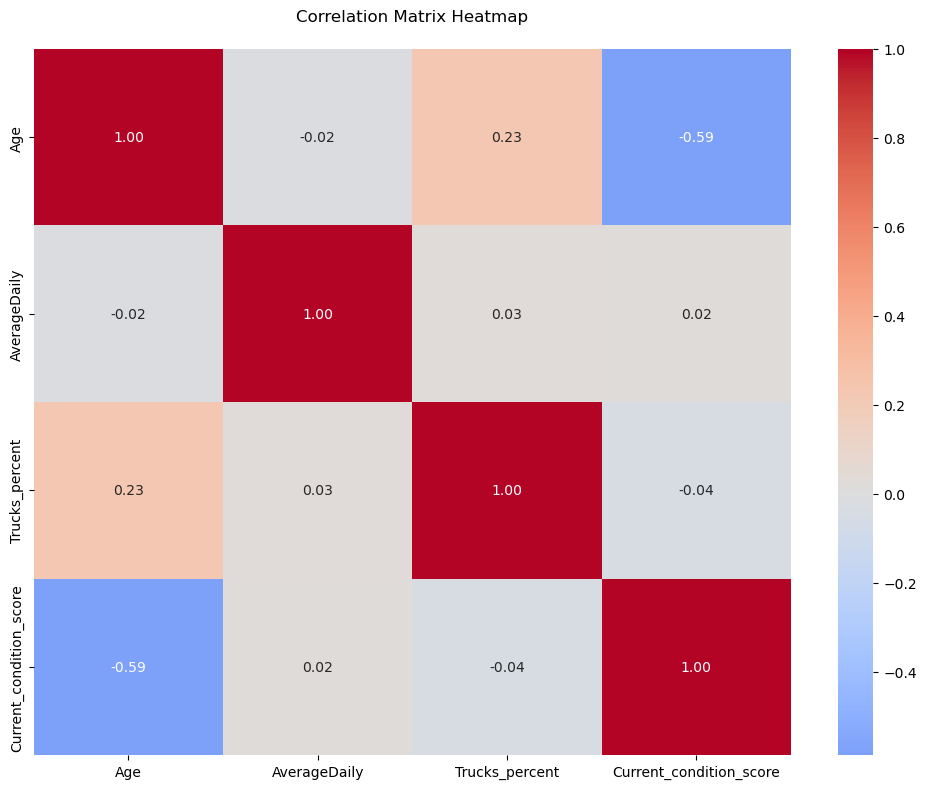

In [27]:
correlation_columns = ['Age', 'AverageDaily', 'Trucks_percent', 'Current_condition_score']
correlation_data = df_clean[correlation_columns]
correlation_matrix = correlation_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix Heatmap', pad=20)
plt.tight_layout()
plt.show()

#### Section 2.1.2 The Scatter Matrix

As a supplement to the correlation matrix, the scatter plot matrix can more intuitively display data relationships. It can show data distribution, linear or nonlinear trends, outliers, etc.

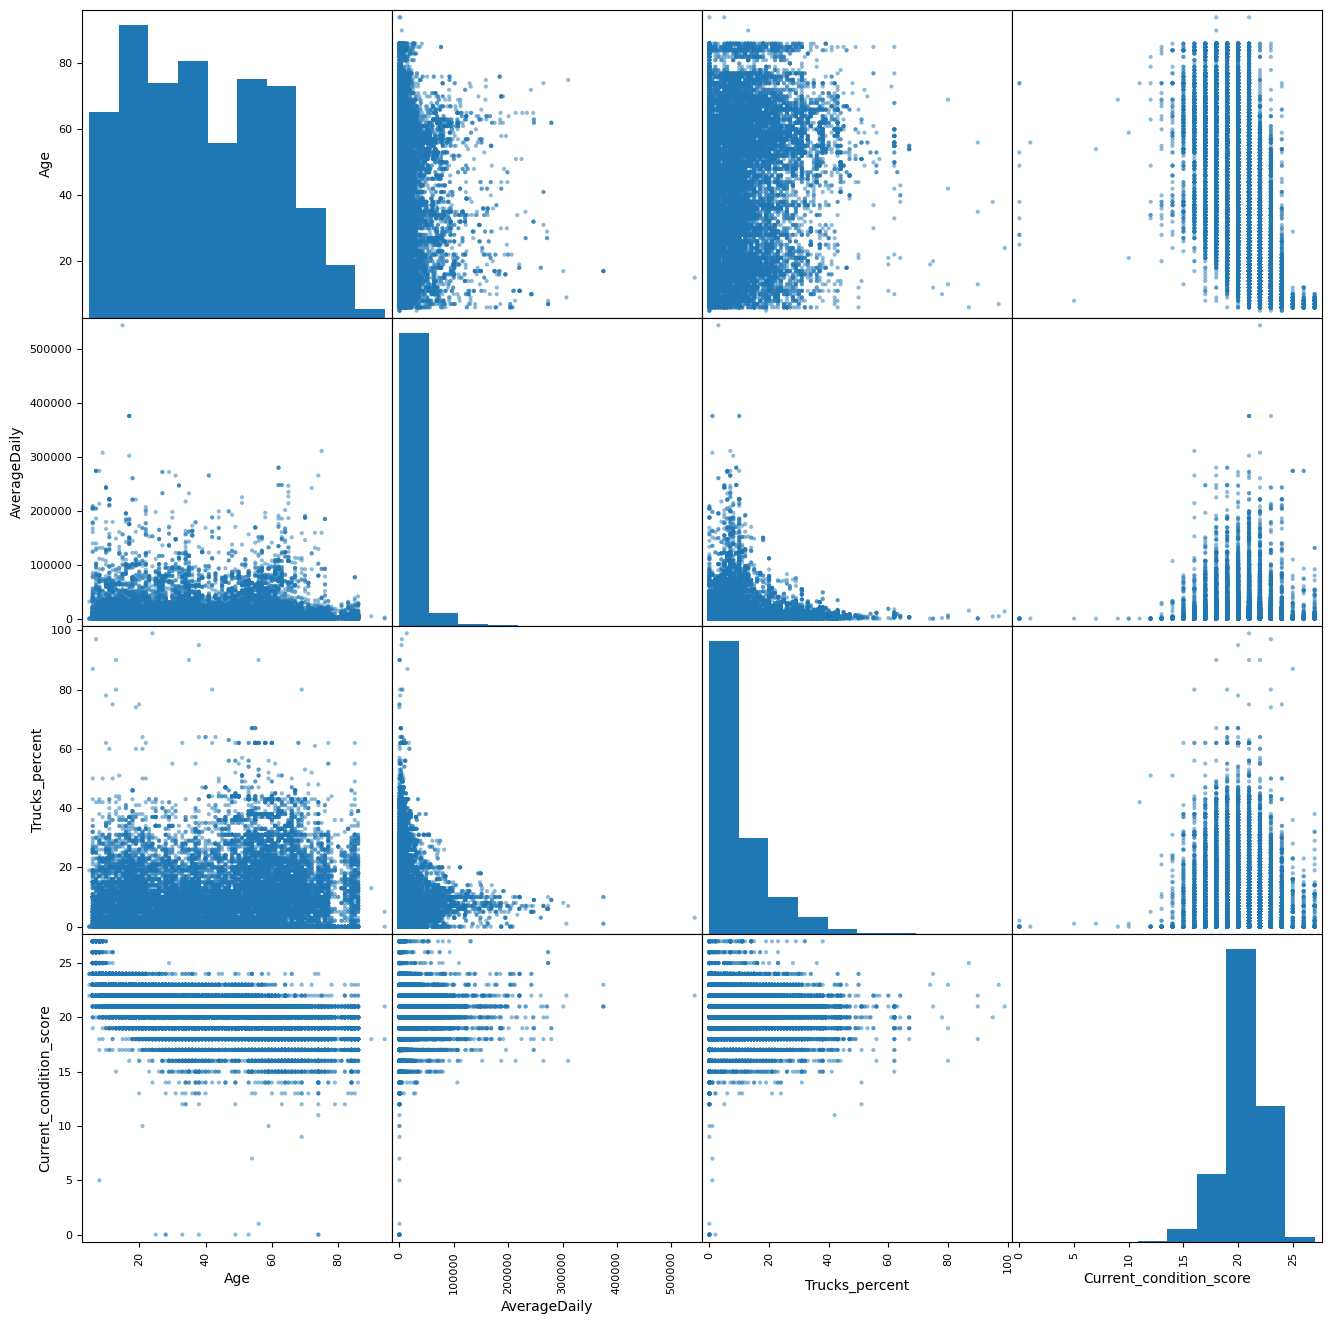

In [29]:
columns_to_plot = ['Age', 'AverageDaily', 'Trucks_percent', 'Current_condition_score']
_a = pd.plotting.scatter_matrix(df_clean[columns_to_plot], figsize=(16, 16), alpha=0.5)

### Section 2.2 Analysis of Category Interactions

This section focuses on analyzing the relationship between categorical variables. It explores visualizing the conditional probability distribution through bar charts, followed by displaying conditional probabilities using heat maps.

#### Section 2.2.1 Distribution Analysis Visualization

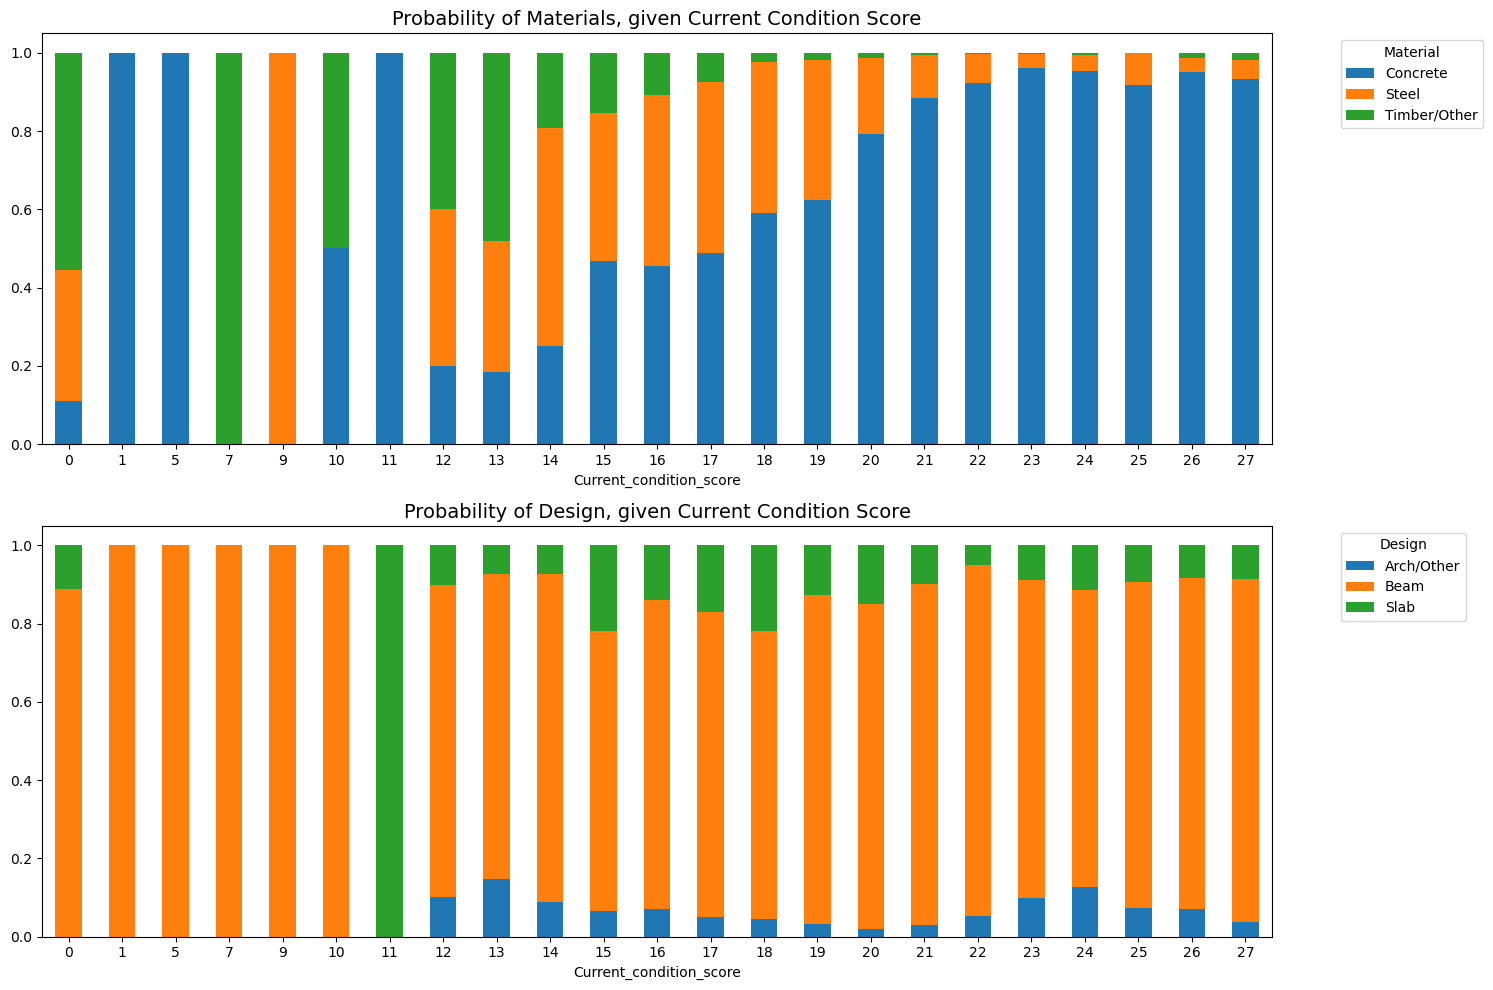

In [31]:
fig, (a1, a2) = plt.subplots(2, 1, figsize=(15, 10))
fig.subplots_adjust(hspace=0.3)

mat_given_cond = pd.crosstab(df_clean.Current_condition_score, [df_clean.Material_Merged], normalize='index')
des_given_cond = pd.crosstab(df_clean.Current_condition_score, [df_clean.Design_Merged], normalize='index')

mat_given_cond.plot(kind='bar', stacked=True, ax=a1, rot=0)
a1.set_title('Probability of Materials, given Current Condition Score', fontsize=14)
a1.legend(title='Material', bbox_to_anchor=(1.05, 1))

des_given_cond.plot(kind='bar', stacked=True, ax=a2, rot=0)
a2.set_title('Probability of Design, given Current Condition Score', fontsize=14)
a2.legend(title='Design', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

#### Section 2.2.2 Conditional Probability Visualization

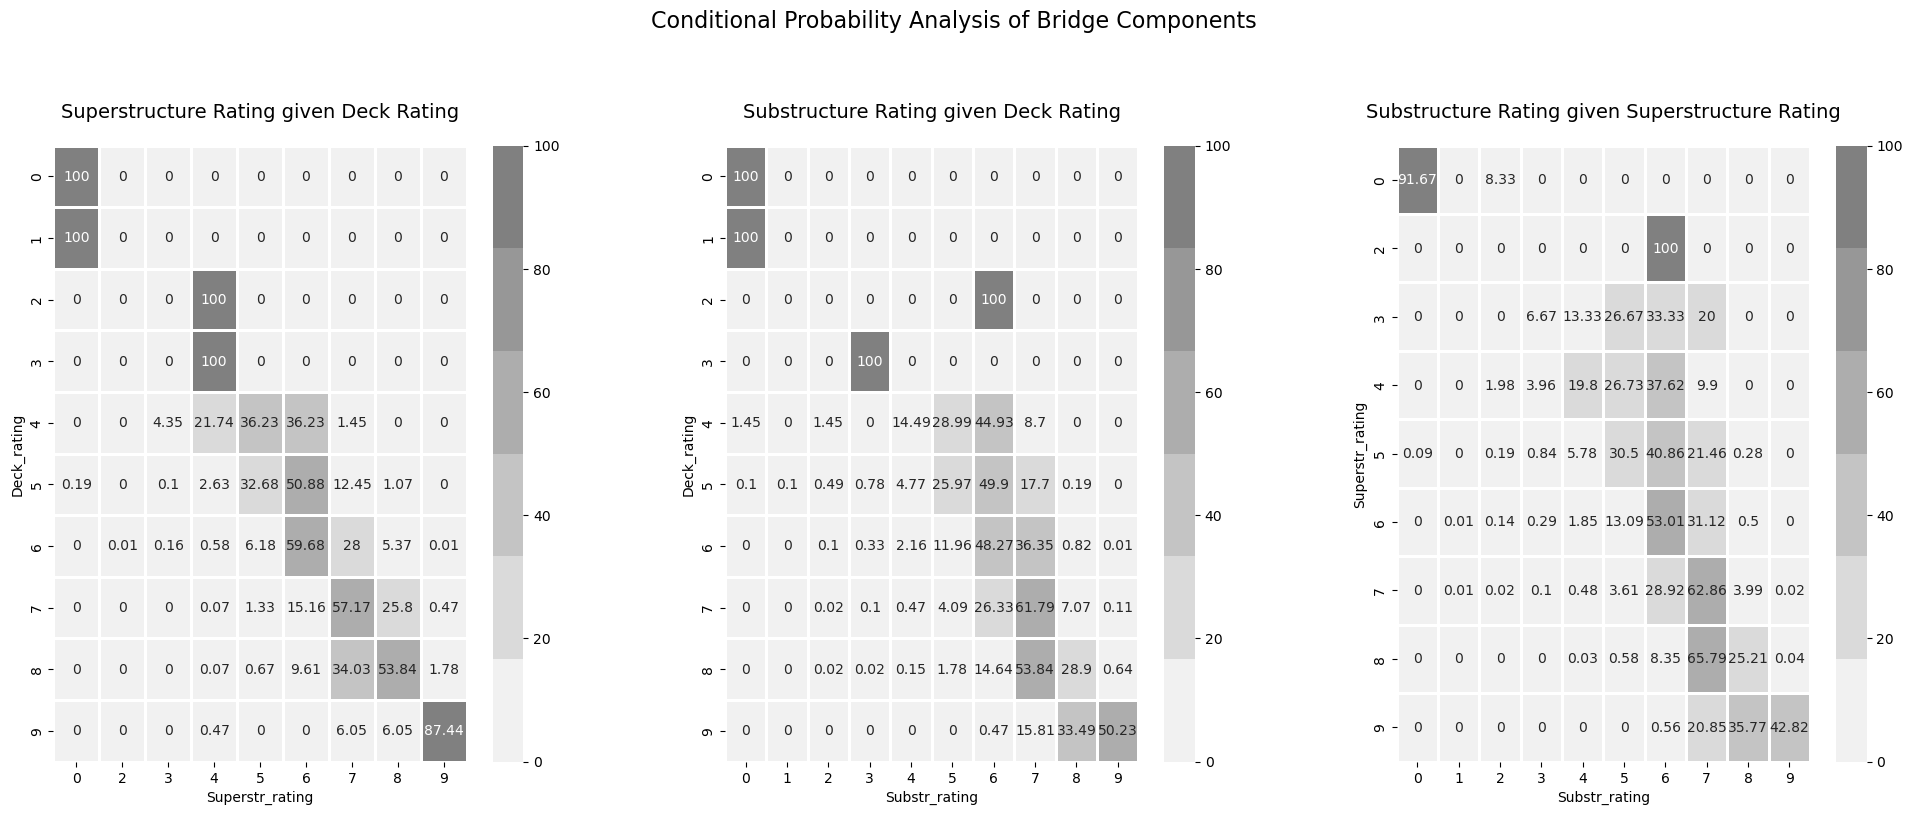

In [33]:
def create_heatmap(data, ax, title):
    sns.heatmap(data.round(4)*100, cmap=sns.light_palette('grey'), linewidths=2,
                annot=True, fmt='g', ax=ax, annot_kws={"size": 10})
    ax.set_title(title, fontsize=14, pad=20)

def plot_component_relationships(df_clean):
    var_pairs = [
        (df_clean.Deck_rating, df_clean.Superstr_rating, 'Superstructure Rating given Deck Rating'),
        (df_clean.Deck_rating, df_clean.Substr_rating, 'Substructure Rating given Deck Rating'),
        (df_clean.Superstr_rating, df_clean.Substr_rating, 'Substructure Rating given Superstructure Rating')]

    fig, axes = plt.subplots(1, 3, figsize=(24, 8))
    plt.subplots_adjust(wspace=0.3)

    for (var1, var2, title), ax in zip(var_pairs, axes):
        crosstab = pd.crosstab(var1, var2, normalize='index')
        create_heatmap(crosstab, ax, title)

    fig.suptitle('Conditional Probability Analysis of Bridge Components',
                 fontsize=16, y=1.05)

    return fig

fig = plot_component_relationships(df_clean)
plt.show()

### Section 2.3 Numerical Variable Patterns Across Categories

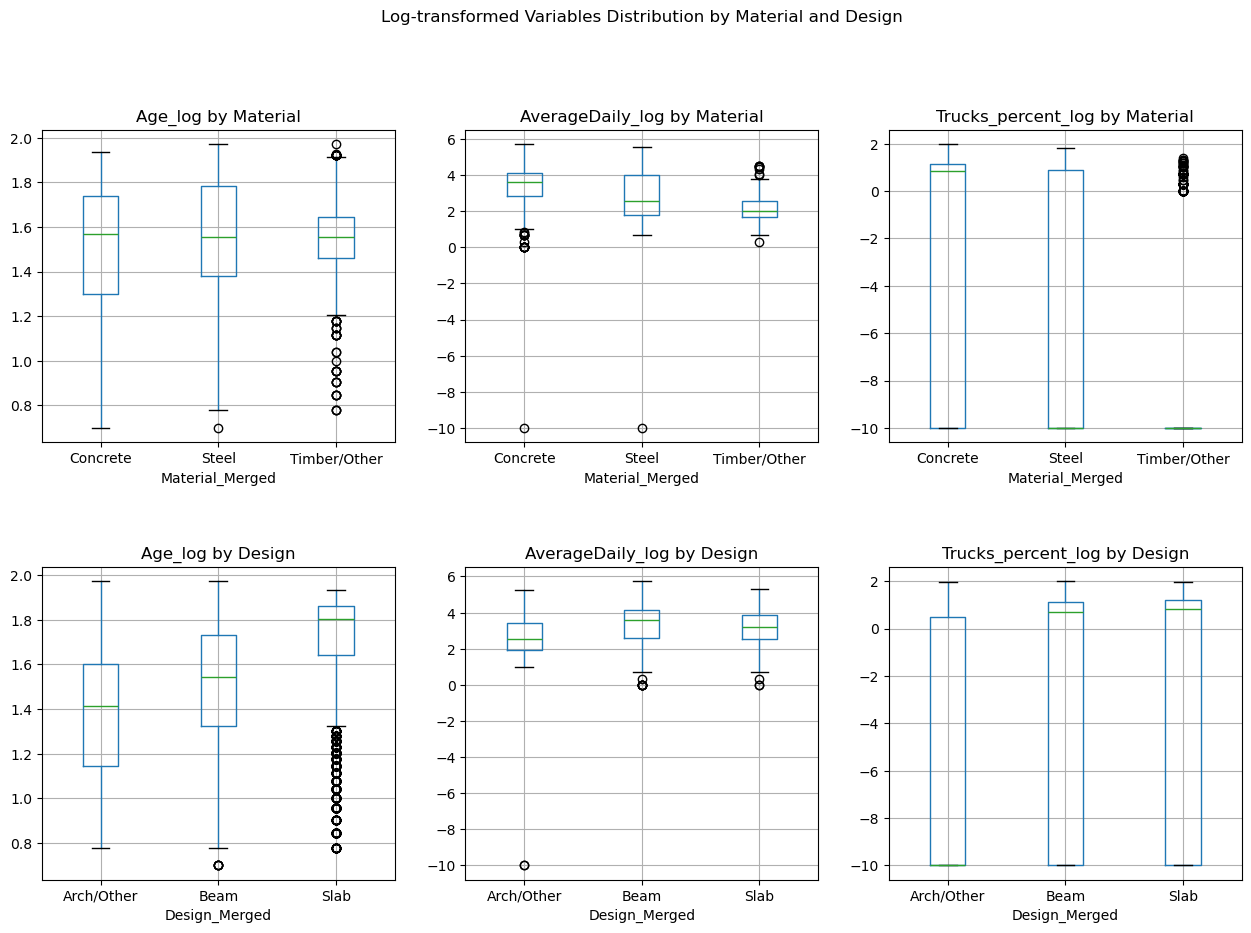

In [35]:
df_log = df_clean.copy()
for col in ['Age', 'AverageDaily', 'Trucks_percent']:
    df_log[f'{col}_log'] = np.log10(df_clean[col] + 1e-10)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

for i, col in enumerate(['Age_log', 'AverageDaily_log', 'Trucks_percent_log']):
    df_log.boxplot(column=col, by='Material_Merged', ax=axes[0,i])
    axes[0,i].set_title(f'{col} by Material')
    axes[0,i].tick_params(axis='x')

for i, col in enumerate(['Age_log', 'AverageDaily_log', 'Trucks_percent_log']):
    df_log.boxplot(column=col, by='Design_Merged', ax=axes[1,i])
    axes[1,i].set_title(f'{col} by Design')
    axes[1,i].tick_params(axis='x')

fig.suptitle('Log-transformed Variables Distribution by Material and Design', y=1.02)

plt.show()

### Section 2.4 Findings of Exploratory Analysis

Relationships among age, average use, percent trucks and bridge condition:

* **Older bidges tend to be in worse condition** - the most significant relationship in this dataset is the negative correlation (-0.59) between age and current condition score, indicating that as the service life increases, the bridge condition score tends to decline, which aligns with normal aging patterns.
* **Older bridges have slightly more truck traffic, but this connection is quite weak** - there is a weak positive correlation (0.23) between age and truck usage percentage
* **Contrary to general expectations** - how many vehicles use the bidge each day doesn't seem to affect its condition much, and even the amount of heavy truck traffic doesn't seem to cause much extra damage

Relationships among material, design and bridge condition:

* **Material Distribution Analysis**: High condition scores (>20) show concrete dominance at 80-90%, while low scores (0-10) display more diverse materials, with timber and other materials (65%) and steel (30%) being prevalent. Mid-range scores demonstrate a transition from mixed materials to concrete dominance.

* **Material-Condition Relationship**: Concrete structures generally exhibit better conditions, whereas steel, timber and other materials tend to receive lower scores, suggesting concrete structures may have better durability or easier maintenance.

* **Design Distribution Analysis**: Beam design dominates across all ranges, exceeding 70%. Slab design appears mainly in higher scores (>20) at 10-15%, while arch and other design types show higher frequency in middle-low score ranges.

* **Design-Condition Relationship**: Beam design demonstrates versatility and reliability across all condition levels. Slab design correlates with better structural conditions, while arch designs are more common in structures of moderate condition, reflecting special purpose characteristics.

* **Key Trends**: Higher scores correlate with uniform materials and designs, predominantly concrete and beam construction. Lower scores show greater diversity, suggesting standardized designs contribute to better conditions and earlier structures likely used more varied solutions.

Relationships among material, design and deck, superstructure and substructure:

* **Key Trends**: Strong correlations exist between deck, superstructure, and substructure conditions. Component interdependencies are strongest in the good condition range (6-9), while lower ratings show more scattered relationships, indicating multiple deterioration modes. Poor condition of one component does not necessarily indicate poor condition of other components, especially at moderate ratings. Superstructure and substructure conditions show the strongest correlations.

* **Component-Condition Relationships**: Deck damage may precede superstructure problems, indicating that deck deterioration may serve as an early warning before superstructure problems occur. A similar, but weaker, relationship exists between deck and substructure condition, indicating that these components may deteriorate independently. Superstructure-substructure shows the strongest relationship, indicating that they often deteriorate together. This close correlation may reflect their structural interdependence and similar environmental conditions, making them more likely to experience similar wear patterns.

Relationship among all variables:

* **Usage Patterns**: Concrete and Beam designs tend to be used for higher-traffic routes, suggesting they're preferred for major thoroughfares. Timber/Other materials and Slab designs are more commonly found on lower-traffic routes.

* **Age Characteristics**: Older bridges tend to be Timber/Other materials with Slab designs, while newer constructions favor Concrete and Steel materials with Beam designs. This reflects the evolution of bridge engineering practices.

* **Traffic Adaptation**: The consistency in truck percentages across designs suggests that bridge design selection is influenced more by total traffic volume than by traffic composition.

* **Modern bridge construction**: It appears to favor more standardized approaches using Concrete and Beam designs across various traffic conditions.



## Section 3: Statistical Modeling and Results Interpretation

This section examines the relationship between bridge characteristics and condition scores through linear regression analysis.

### Section 3.1: Model Development

In [38]:
# Prepare target variable
y = df_clean['Current_condition_score']

# Create one-hot encoded arrays for categorical variables
material_encoded = pd.get_dummies(df_clean['Material_Merged'], prefix='Material')
design_encoded = pd.get_dummies(df_clean['Design_Merged'], prefix='Design')

# Combine all features using column_stack
X = np.column_stack((df_clean.Age, df_clean.AverageDaily, df_clean.Trucks_percent,
    material_encoded, design_encoded))

# Create feature names list
feature_names = ['Age', 'AverageDaily', 'Trucks_percent'] + \
                material_encoded.columns.tolist() + \
                design_encoded.columns.tolist()

# Fit linear regression model
reg = LinearRegression().fit(X, y)

# Print all coefficients
print('\nRegression Coefficients:')
print('-' * 40)
for name, coef in zip(feature_names, reg.coef_):
    print(f'{name:25}: {coef:10.3f}')

# Calculate and display ranges for continuous variables
print('\nContinuous Variables Range Information:')
print('-' * 70)
continuous_vars = ['Age', 'AverageDaily', 'Trucks_percent']
for var in continuous_vars:
    min_val = df_clean[var].min()
    max_val = df_clean[var].max()
    mean_val = df_clean[var].mean()
    std_val = df_clean[var].std()
    print(f'{var:15} - Range: [{min_val:.1f}, {max_val:.1f}], Mean: {mean_val:.1f}, Std: {std_val:.1f}')


Regression Coefficients:
----------------------------------------
Age                      :     -0.054
AverageDaily             :     -0.000
Trucks_percent           :      0.006
Material_Concrete        :      1.388
Material_Steel           :      0.045
Material_Timber/Other    :     -1.434
Design_Arch/Other        :      0.043
Design_Beam              :     -0.038
Design_Slab              :     -0.004

Continuous Variables Range Information:
----------------------------------------------------------------------
Age             - Range: [5.0, 94.0], Mean: 39.3, Std: 20.7
AverageDaily    - Range: [0.0, 543000.0], Mean: 12064.3, Std: 24857.3
Trucks_percent  - Range: [0.0, 99.0], Mean: 8.4, Std: 10.3


### Section 3.2: Model Performance Metrics

In [40]:
# Print model evaluation metrics
print('Model Evaluation Results:')
print('-' * 30)
print(f'R2 Score: {reg.score(X, y):.3f}')
print(f'Intercept: {reg.intercept_:.3f}')

Model Evaluation Results:
------------------------------
R2 Score: 0.451
Intercept: 21.443


This indicator means that the model can explain 45.1% of the variation in bridge conditions. The predicted variables have a substantial impact on bridge conditions, but the predictive ability is only at a medium level. There is still a large proportion of variation (54.9%) that cannot be explained by the current variables, indicating that there may be other important influencing factors that are not included.

### Section 3.3: Distribution of Residuals

In [42]:
# Calculate and print error metrics
y_pred = reg.predict(X)
mse = np.mean((y - y_pred) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y - y_pred))

print('\nError Metrics:')
print('-' * 40)
print(f'Mean Squared Error (MSE)      : {mse:.3f}')
print(f'Root Mean Squared Error (RMSE) : {rmse:.3f}')
print(f'Mean Absolute Error (MAE)      : {mae:.3f}')


Error Metrics:
----------------------------------------
Mean Squared Error (MSE)      : 2.074
Root Mean Squared Error (RMSE) : 1.440
Mean Absolute Error (MAE)      : 1.073


The error indicator shows that the prediction deviation is within the acceptable range.

### Section 3.4: Comparing the Effects of Predictor Variables

Based on the regression analysis results, we can compare the influence of the predictor variables:

* **Material** type emerges as the most influential predictor, with concrete showing a strong positive coefficient (+1.388), timber displaying a significant negative effect (-1.434), and steel exhibiting a relatively modest impact (+0.045).

* Although the regression coefficient of **age** seems small (-0.054), its actual impact is more significant when considering the large range of values ​​of the age variable (from 5 to 94 years, a span of 89 years): when a bridge goes from the youngest (5 years) to the oldest (94 years), the potential overall decrease in its condition score can reach: -0.054 × (94 - 5) = -4.81 points. This shows that although age has a small coefficient, it is actually a fairly important predictor variable due to its large range of values. It indicates a gradual deterioration over time.

* The effects of **design** type are relatively small compared to the effects of material type and age, with beam and arch designs showing limited predictive power, and slab design having almost no effect.

* The analysis also identifies several variables with **minimal predictive significance**, including truck percentage and average daily traffic. Despite the wide range in average daily traffic volumes (from 0 to 543000) and percentage of trucks (from 0 to 99%), the impact is still negligible.

### Section 3.5: Conclusion and Recommendation

Overall conclusions:

* **Material** type is the most important factor affecting facility condition, with concrete having a significant positive effect, while other materials significantly reduce condition scores.

* **Age** does cause condition scores to decrease, but the effect is not as large as expected, which may indicate that maintenance work is effective.

* **Traffic load** (average daily vehicle volume and truck ratio) has an unexpectedly small effect on facility condition, which may indicate that the facility design meets traffic load requirements or that maintenance work is carried out in a timely manner.

* The effect of **design** type is relatively moderate, indicating that the performance differences between different design types are not significant.

* The **model's predictive ability** is moderate, indicating that there may be **other important factors** that have not been included in the model, such as maintenance history, climate conditions, construction quality, usage environment, etc.

Recommendations:

* Consider **introducing additional predictor variables** to improve model explanatory power: maintenance history and frequency, environmental exposure, construction quality indicators, other measures of usage intensity, inspection and evaluation records

* **Optimize existing variables**: redesign traffic load indicators, refine material classification or increase design details.

* **Model optimization**:
  * Explore nonlinear relationships: introduce interaction terms, or use polynomial features, or explore other modeling methods, such as random forests (to eliminate multicollinearity effects) or neural networks
  * Enhance predictive capabilities: such as hierarchical modeling or time series feature extraction

* **Practical application suggestions**: In the short term, use as a preliminary screening tool to identify high-risk factors. Long-term planning requires continuous data collection, regular model updates and improved prediction accuracy.